# Aufgabe 1 - Simulationskette für Neutrinodetektor

In [17]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
# Normed Flux of the Neutrinos
def phi(E):
    return 17/10*E**(-2.7)


def inverseCDFOfPhi(E):
    return (1-E)**(-10/17)


# A neutrino with energy E is detected with the probability P(E)
def P(E):
    return (1-np.exp(-E/2))**3

## Teilaufgabe a) - Signal MC
Wir wollen zuerst die Energieverteilung (Fluss) der Neutrinos generieren. Dazu betrachten wir ein theoretisches Potenzgesetz (siehe Aufgabe) und samplen die Energien mit dem Inversion Sampling. Später wird es auch grafisch dargestellt.

In [19]:
amountOfSamples = int(1e5)
energyLinspace = np.linspace(1,10000,10000) # to plot the generated energy sample later on
prng = random.RandomState(42) # A mersenne twister generator
uniform1 = prng.uniform(size=amountOfSamples) # 1e5 pseudo random numbers, which are uniformly distributed in 0 to 1, 1 not included
energy = inverseCDFOfPhi(uniform1) # using inversion sampling
dfEnergy = pd.DataFrame(data=energy[0:], index=np.arange(0,amountOfSamples), columns=['Energy']) # Making a new df

## Teilaufgabe b) - Akzeptanz
Nun wollen wir beachten, dass der Detektor die Neutrinos nicht sicher, sondern nur mit einer Wahrscheinlichkeit $P(E) < 1$ detektiert (Für die Verteilung siehe Aufgabenstellung). Wir benutzen die Neumannsche Rückweisungsmethode in einer Variante, wo Booleans generiert werden: True, falls die Zahl angenommen wird und False, falls sie abgelehnt wird.
Dabei generieren wir direkt ein Array und vergleichen sofort jedes Element.

In [20]:
prng = random.RandomState(43) # change the seed to get reproducible results
uniform2 = prng.uniform(size=amountOfSamples) # a second array to perform the neumann rejection sampling
mask = uniform2 < P(energy) # a boolean array containing true, false, true, ...
# at index i the value is true, if the neutrino with energy[i] got detected successfully, otherwise the value is false.
energyDetected = energy[mask == True] # In this array only the energies of the successfully detected neutrinos are stored
dfMask = pd.DataFrame(data=mask[0:], index=np.arange(0,amountOfSamples), columns=['AcceptanceMask'])
dfTwo = pd.concat([dfEnergy,dfMask], axis=1)

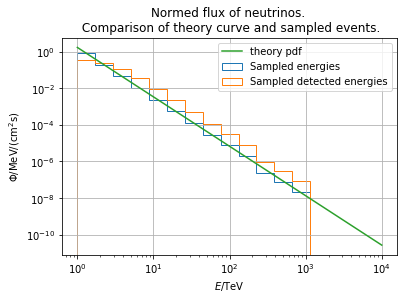

In [21]:
# Grafische Veranschaulichung
plt.hist(energy, normed=True, bins=10 ** np.linspace(np.log10(1), np.log10(10000), 18), label='Sampled energies', histtype='step')
plt.hist(energyDetected, normed=True, bins=10 ** np.linspace(np.log10(1), np.log10(10000), 18), label='Sampled detected energies', histtype='step')
plt.plot(energyLinspace, phi(energyLinspace), label='theory pdf')
plt.grid()
plt.legend()
plt.xlabel(r'$E/\mathrm{TeV}$')
plt.ylabel(r'$\Phi/\mathrm{MeV/(cm^2 s)}$')
plt.yscale('log')
plt.xscale('log')
plt.title('Normed flux of neutrinos. \n Comparison of theory curve and sampled events.')
plt.show()
plt.clf()

Die Kurve zeigt den erwarteten Verlauf. Doppeltlogarithmisch aufgetragen ergibt sich eine Gerade, da der Fluss ein Potenzgesetz darstellt. Die blaue Kurve durchschneidet die PDF im Zickzack, sodass die Fläche unter beiden Kurven (fast gleich) ist, so wie es bei einem normierten Histogramm gefordert ist. Dies ist bei der orangefarbenen Kurve auch so, weil sie am Anfang unter der grünen Kurve liegt und später drüber. Der Anfang ist aufgrund der doppeltlogarithmischen Auftragung viel stärker zu gewichten, sodass sich es ausgleicht.

## Teilaufgabe c) - Energiemessung
Die Energie der Neutrinos kann nicht direkt gemessen werden. Stattdessen sei die Energie korreliert mit der Anzahl an ansprechenden Photomultipliern ("Hits"). Die Hits folgen in der Abhängigkeit der Energie einer Normalverteilung (Details auf dem Blatt). Wir ziehen durch Anwendung der Polarmethode diese Zahlen und transformieren sie entsprechend.

In [22]:
def genNumberOfHitsS(energy):
    i = 0
    while i < 1e5:
        v1 = prng.uniform(-1,1)
        v2 = prng.uniform(-1,1)
        s = v1**2+v2**2
        if s < 1:
            temp = np.sqrt(-2/s*np.log(s)) # we need this twice later so we calculate it beforehand
            n1 = 2*energy[i]*v1*temp + 10*energy[i] # Applying a linear transformation to the standard normal distribution
            n2 = 2*energy[i+1]*v2*temp + 10*energy[i+1] # If x ~ N(0,1), then x'=sig*x+mu and x' is distributed with
            # standard distribution sig and mean mu.
            n1 = np.round(n1) # only a whole number of hits is possible
            n2 = np.round(n2)
            if n1 > 0: # only a positive number of hits is possible
                numberOfHits.append(n1)
                i += 1
            if n2 > 0:
                numberOfHits.append(n2)
                i += 1
    return numberOfHits

In [23]:
prng = random.RandomState(44)
numberOfHits = []
numberOfHits = genNumberOfHitsS(energy)
dfHits = pd.DataFrame(data=numberOfHits[0:], index=np.arange(0,amountOfSamples), columns=['NumberOfHits'])
dfThree = pd.concat([dfTwo,dfHits], axis=1)

## Teilaufgabe d) - Ortsmessung
Der Detektor ermittelt auch die Orte der gemessenen Neutrinos. Diese folgen einer Normalverteilung mit Mittelwert $(7,3)$ (weitere Angaben auf dem Blatt). Wir verwenden erneut die Polarmethode, um die Zahlen zu erzeugen. Anschließend werden die Orte zweidimensional histogrammiert.

In [24]:
r0 = np.array([7,3])
prng = random.RandomState(45)
xArray = []
yArray = []
i = 0
for i in range(0, amountOfSamples):
    success = successx = successy = False
    while success is False:
        v1 = prng.uniform(-1,1)
        v2 = prng.uniform(-1,1)
        s = v1**2+v2**2
        if s < 1:
            temp = np.sqrt(-2/s*np.log(s)) # we need this twice later so we calculate it beforehand
            x = 1/(np.log10(numberOfHits[i]+1))*v1*temp + 7 # Applying a linear transformation to the standard normal distribution
            y = 1/(np.log10(numberOfHits[i]+1))*v2*temp + 3 # If x ~ N(0,1), then x'=sig*x+mu and x' is distributed with
            # standard distribution sig and mean mu.
            if (0 <= x <= 10) and (successx == False): # We only need an x value if we dont already have one and if the generated x is
            # inside the detector
                xArray.append(x)
                successx = True
            if (0 <= y <= 10) and (successy == False):
                yArray.append(y)
                successy = True
            success = successx and successy
dfx = pd.DataFrame(data=xArray[0:], index=np.arange(0,amountOfSamples), columns=['x'])
dfy = pd.DataFrame(data=yArray[0:], index=np.arange(0,amountOfSamples), columns=['y'])
dfFour = pd.concat([dfThree,dfx, dfy], axis=1)
dfFour.to_hdf('NeutrinoMC.hdf5', key='Energy')

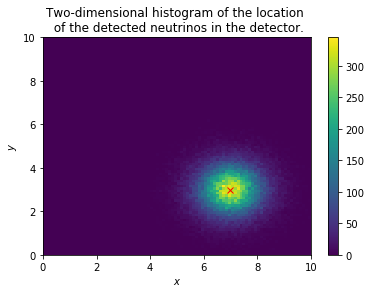

In [25]:
plt.hist2d(xArray,yArray, bins=[90,90], range=[[0,10],[0,10]], cmap='viridis')
plt.plot(7,3,'rx')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Two-dimensional histogram of the location \n of the detected neutrinos in the detector.')
plt.show()
plt.clf()

## Teilaufgabe e) - Untergrund MC

In [26]:
def genxyU(rho, mu, sigma):
    """Generates two gaussian random numbers with correlation rho, stdev sigma and mean mu, which are required to lie in
    [0,10]x[0,10]."""
    success = False
    while success == False:
        x = prng.normal(loc=0, scale=1) # get two standard gaussian dsitributed variables
        y = prng.normal(loc=0, scale=1)
        x = np.sqrt(1-rho*rho)*sigma*x + rho*sigma*y+mu # transform them so they are distributed as stated above
        y = sigma*y + mu
        if (0 <= x <= 10) and (0 <= y <= 10): # only accept them if they are inside the bounds of the detector
            success = True
    return (x,y)

def genNumberOfHitsU(mu, sigma, size):
    array = []
    while len(array) < size:
        x = prng.normal(loc=mu, scale=sigma)
        if x > 0:
            array.append(x)
    return array

In [27]:
prng = random.RandomState(46)
sizeOfU = int(1e7)
log10NumberOfHitsU = prng.normal(loc=2, scale=1, size=sizeOfU)
log10NumberOfHitsU = genNumberOfHitsU(mu = 2, sigma = 1, size=sizeOfU)
#xUArray = prng.normal(loc=0, scale=1, size=sizeOfU)
#yUArray = prng.normal(loc=0, scale=1, size=sizeOfU)
# Now we perform the transformation to correlated variables as explained in the assignment
rho = 0.5
sigma = 3
#mux = 5
#muy = 5
#xUArray = np.sqrt(1-rho*rho)*sigma*xUArray + rho*sigma*yUArray+mux
#yUArray = sigma*yUArray + muy
xUArray = []
yUArray = []
for i in range(0, sizeOfU):
    x, y = genxyU(rho=0.5, mu=5, sigma=3)
    xUArray.append(x)
    yUArray.append(y)
xUArray = np.asarray(xUArray)
yUArray = np.asarray(yUArray)

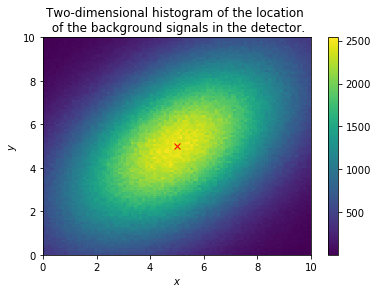

In [28]:
plt.hist2d(xUArray,yUArray, bins=[100,100], range=[[0,10],[0,10]], cmap='viridis')
plt.plot(5,5,'rx')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Two-dimensional histogram of the location \n of the background signals in the detector.')
plt.show()
plt.clf()

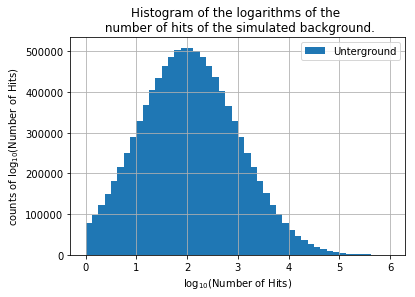

In [29]:
plt.hist(log10NumberOfHitsU, bins=48, range=[0,6], label='Unterground', histtype='stepfilled')
plt.grid()
plt.xlabel(r'$\mathrm{log}_{10}$(Number of Hits)')
plt.ylabel(r'counts of $\mathrm{log}_{10}$(Number of Hits)')
plt.legend()
plt.title('Histogram of the logarithms of the \n number of hits of the simulated background.')
plt.show()
plt.clf()

In [30]:
log10NumberOfHitsU = np.asarray(log10NumberOfHitsU)
NumberOfHitsU = 10**(log10NumberOfHitsU)
dfHits = pd.DataFrame(data=NumberOfHitsU[0:], index=np.arange(0,sizeOfU), columns=['NumberOfHits'])
dfx = pd.DataFrame(data=xUArray[0:], index=np.arange(0,sizeOfU), columns=['x'])
dfy = pd.DataFrame(data=yUArray[0:], index=np.arange(0,sizeOfU), columns=['y'])
dfU = pd.concat([dfHits,dfx, dfy], axis=1)

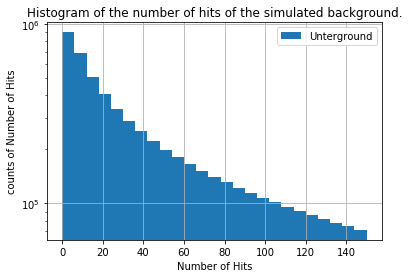

In [31]:
plt.hist(NumberOfHitsU, bins=25, range=[0,150], label='Unterground', histtype='stepfilled')
plt.grid()
plt.xlabel(r'Number of Hits')
plt.ylabel(r'counts of Number of Hits')
plt.yscale('log')
plt.title('Histogram of the number of hits of the simulated background.')
plt.legend()
plt.show()
plt.clf()

In [32]:
dfFour.to_hdf('NeutrinoMC.hdf5', key='Background', append=True)